# CIFAR-10 Image Classifier
Udacity Intro to Machine Learning with PyTorch Nanodegree Project 2

## Table of Contents
- [1. Introduction](#1.)
    - [1.1 Project Motivation](#1.1)
    - [1.2 The Dataset](#1.2)
    - [1.3 Outline of the Project](#1.3)
    - [1.4 Python Libraries Imports](#1.4)
- [2. Preparing and Exploring CIFAR-10 Dataset](#2.)
    - [2.1 Loading the Dataset](#2.1)
    - [2.2 Exploring the Dataset](#2.2)
- [3. Building a Neural Network Classifier](#3.)
    - [3.1 Neural Network Architecture](#3.1)
    - [3.2 Model Loss Function & Optimiser](#3.2)
- [4. Model Training](#4.)
- [5. Model Testing](#5.)
- [6. Saving the Model](#6.)
- [7. Recommendation](#7.)

---
<a id='1.'></a>
## 1. Introduction 

<a id='1.1'></a>
### 1.1 Project Motivation
The management of a fictional self-driving car startup is trying to decide whether to build or buy an object detection algorithm for objects that may be on the side of the road. They are considering buying a computer vision algorithm from a company called Detectocorp. Detectocorp’s algorithm claims a 70% accuracy rate on the CIFAR-10 dataset, a benchmark used to evaluate the state-of-the-art for computer vision systems.

But before making this purchase, management wants to explore whether it is possible to build an in-house solution that performs well. The aim of this project is to try and create a neural network that can classify arbitrary objects and potentially be fine-tuned on a larger dataset using transfer learning.

Ultimately, the task is to build an image classifier using the CIFAR-10 dataset and evaluate its accuracy. Then compare its performance to both Detectocorp’s algorithm (which achieved 70% accuracy) as well as the published state-of-the-art results and make a recommendation to management about whether to build the solution in-house or buy the algorithm from Detectocorp.

<a id='1.2'></a>
### 1.2 The Dataset
The image classifier will be trained and evaluated on one of the most classic and well-studied computer vision data sets, CIFAR-10. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. It is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. This dataset has spurred loads of innovation in neural network design and implementation.

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

The current state of the art is a 99% accuracy rate, achieved by GPipe, which has 557 million parameters and was developed in late 2018. Research with this dataset is still ongoing, and many of these networks are quite large and quite expensive to train. Therefore, it is important to note that advanced techniques used in the neural networks above are out of the scope of this project and the Intro to Machine Learning with PyTorch Nanodegree. Hence, the target accuracy is 70%, but any accuracy over 50% is a great start.

<a id='1.3'></a>
### 1.3 Outline of the Project
The rest of the prohject is organised as follows:

* Section 2: Exploring and preparing the data for training and testing
* Section 3: Designing and building the neural network.
* Section 4: Training the neural network on the training set.
* Section 5: Evaluating the network's performance on the test set.
* Section 6: Making a recommendation on the build vs. buy business decision.

<a id='1.4'></a>
### 1.4 Python Libraries Imports

In [1]:
# Load main libraries needed for the project 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---
<a id='2.'></a>
## 2. Preparing and Exploring CIFAR-10 Dataset

<a id='2.1'></a>
### 2.1 Loading the Dataset
CIFAR-10 is included in the torchvision module. The dataset is created using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#cifar)).

The training data is augmented through random rotations and horizontal flips. This is done in order to increase the number of varying images available by slightly changing the existing images. This will improve the model as it will likely reduce overfitting during the training stage. However, the model will be tested only on the original images present in the CIFAR-10 dataset. Hence the validation dataset, that will be used to check whether the model will be overfitting, will also include only the original data.

Train, validation and test loaders are created in order to train and valuate the model on batches of images with the chosen batch size of 32 images.

In [2]:
# Define transforms for training and test data
train_transforms = transforms.Compose([transforms.Resize(32),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# Specify batch size
batch_size = 32

# Create training set
train_set = torchvision.datasets.CIFAR10('CIFAR10_data/', download=True, train=True, 
                                          transform=train_transforms)
# Define test and validation dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Create test set and validation set
test_data = torchvision.datasets.CIFAR10('CIFAR10_data/', download=True, train=False, 
                                          transform=test_transforms)

test_size = int(len(test_data)*0.8) # 90% of test data is the testing set
val_size = int(len(test_data) - test_size) # 10% of test data is the validation set
test_set, val_set = torch.utils.data.random_split(test_data, [test_size, val_size])

# Define test and validation dataloaders
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


<a id='2.2'></a>
### 2.2 Exploring the Dataset
This section explores and visualises the dimensions of the CIFAR-10 dataset using Numpy, Matplotlib and Pytorch.

In [3]:
# Check the sizes of the datasets
print('Number of images in the training set:', len(train_set))
print('Number of images in the validation set:', len(val_set))
print('Number of images in the test set:', len(test_set))
print('Total number of images in the CIFAR-10 dataset:', len(train_set)+len(val_set)+len(test_set))

Number of images in the training set: 50000
Number of images in the validation set: 2000
Number of images in the test set: 8000
Total number of images in the CIFAR-10 dataset: 60000


The overall data is split into batches where each batch contains the number of images specified in the previous section. The specified batch size is 32, and thus, there are 32 images per batch which corresponds to the first value in the tensor. Secondly, since this dataset consists of coloured images, each image has corresponding red, green and blue colour channel values. Lastly, the images have a 32x32 pixel arrangement. Hence, the overall tensor shape is `(32, 3, 32, 32)`.

In [4]:
# Exploring a random batch of images for its properties
dataiter = iter(train_loader)
dataiter_test = iter(test_loader)
images, labels = dataiter.next()
images_test, labels_test = dataiter_test.next()
print('The shapes of training and testing data are the same?', images.shape == images_test.shape)
print('Overall shape of image batch data:', images.shape)
print('Number of images in each batch:', images.shape[0])
print('Shape of each image:', images[0].shape)

The shapes of training and testing data are the same? True
Overall shape of image batch data: torch.Size([32, 3, 32, 32])
Number of images in each batch: 32
Shape of each image: torch.Size([3, 32, 32])


In order to visualise the images in the training and testing data, the function below was created. This function was created with reference to the [PyTorch's tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) for training the same dataset. Note that the normalisation of images was reversed to have better visualisations.

In [5]:
# Create a function to show a number of images from a dataset based on input
def show_images(img_loader, img_num):
    dataiter = iter(img_loader)
    batch = next(dataiter)
    labels = batch[1][0:img_num]
    images = batch[0][0:img_num]
    fig = plt.figure(figsize=(15,5))
    for i in range(img_num):
        ax = fig.add_subplot(1, img_num, i+1, xticks=[], yticks=[])
        ax.set_title(classes[labels[i]])
        image = (images[i] / 2 + 0.5).numpy()
        plt.imshow(np.transpose(image, (1, 2, 0)))

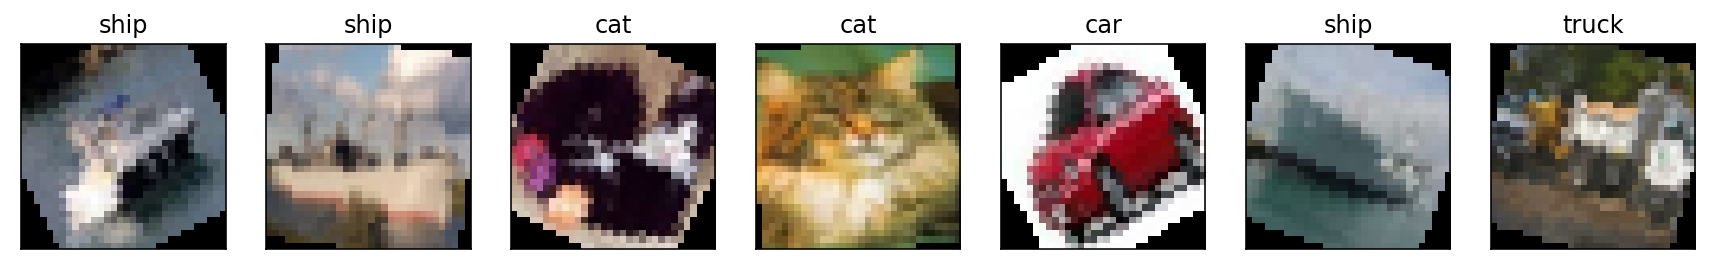

In [6]:
show_images(train_loader, 7)

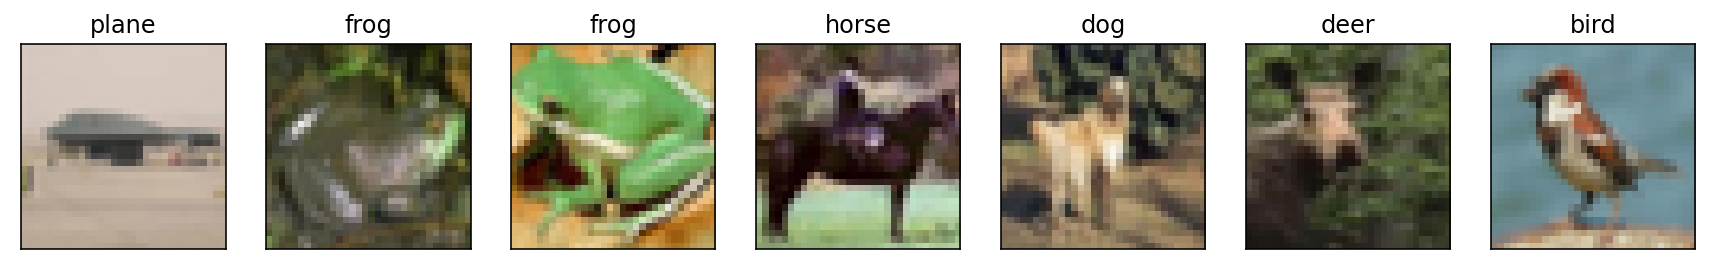

In [7]:
show_images(test_loader, 7)

---
<a id='3.'></a>
## 3. Building a Neural Network Classifier

<a id='3.1'></a>
### 3.1 Neural Network Architecture

The structure of the network was produced with reference to [PyTorch's tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) and [Microsoft's PyTorch tutorial](https://docs.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model).

The network consists of the following types of layers:
* `Conv2d` 
    * Each of the layers has a number of channels to detect specific features in images and a number of kernels to define the size of the detected feature.
    * For instance, the first convolution layer with in_channels=3, out_channels=6, and kernel_size=5 will get the RGB image (3 channels) as an input, and it will apply 6 feature detectors to the images with the kernel size of 5x5.
    * [PyTorch Documnetation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* `BatchNorm2d`
    * Applies normalization on the inputs to have zero mean and unit variance and increase the network accuracy.
    * [PyTorch Documnetation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
* `MaxPool2d`
    * Helps to ensure that the location of an object in an image will not affect the ability of the neural network to detect its specific features.
    * [PyTorch Documnetation](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
* `Linear`
    * Fully connected layers that apply a linear function on the input data.
    * These are the final layers in the network, which compute the scores of each of the classes. In the CIFAR10 dataset, there are ten classes of labels. The label with the highest score will be the one model predicts. 
    * [PyTorch Documnetation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

Other features of the network:
* `ReLU`
    * ReLU is the activation function.
    * [PyTorch Documnetation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* `Dropout`
    * Randomly zeroes some of the elements of the input tensor with probability `p`.
    * This is done to prevent overfitting of the model.
    * [PyTorch Documnetation](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [8]:
class CIFAR10_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*10*10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # Dropout module with 0.1 drop probability
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input):
        output = self.dropout(F.relu(self.bn1(self.conv1(input))))
        output = self.dropout(F.relu(self.bn2(self.conv2(output))))
        output = self.dropout(F.relu(self.bn3(self.conv3(output))))
        output = self.pool(output)
        output = output.view(output.shape[0], -1)
        output = self.dropout(F.relu(self.fc1(output)))
        output = self.dropout(F.relu(self.fc2(output)))

        # Output without dropout
        output = F.log_softmax(self.fc3(output), dim=1)

        return output

<a id='3.2'></a>
### 3.2 Model Loss Function & Optimiser
* Loss Function: Cross Entropy Loss 
* Optimizer: Stochastic Gradient Descent

In [9]:
model = CIFAR10_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

---
<a id='4.'></a>
## 4. Model Training
The model is trained in this section by iterating through batches of images and using Stochastic Gradient Descent to update the weights within the model. Validation data is used in order to monitor the loss throughout epochs to ensure that there is no overfitting. Validation data is used as the testing data should only be used during the testing stage.

In [10]:
# Use the GPU of the machine if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on', device)
model.to(device)

Running on cuda


CIFAR10_model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [11]:
# Train the model
epochs = 30

train_losses = []
val_losses = []
val_accuracies =[]

for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        val_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                val_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(accuracy/len(val_loader))

        print('Epoch: {}/{}.. '.format(epoch+1, epochs),
              'Training Loss: {:.3f}.. '.format(running_loss/len(train_loader)),
              'Validation Loss: {:.3f}.. '.format(val_loss/len(val_loader)),
              'Validation Accuracy: {:.3f}'.format(accuracy/len(val_loader)))

Epoch: 1/30..  Training Loss: 1.743..  Validation Loss: 1.461..  Validation Accuracy: 0.472
Epoch: 2/30..  Training Loss: 1.483..  Validation Loss: 1.348..  Validation Accuracy: 0.521
Epoch: 3/30..  Training Loss: 1.391..  Validation Loss: 1.282..  Validation Accuracy: 0.535
Epoch: 4/30..  Training Loss: 1.321..  Validation Loss: 1.206..  Validation Accuracy: 0.574
Epoch: 5/30..  Training Loss: 1.278..  Validation Loss: 1.197..  Validation Accuracy: 0.572
Epoch: 6/30..  Training Loss: 1.232..  Validation Loss: 1.138..  Validation Accuracy: 0.597
Epoch: 7/30..  Training Loss: 1.197..  Validation Loss: 1.080..  Validation Accuracy: 0.623
Epoch: 8/30..  Training Loss: 1.163..  Validation Loss: 1.061..  Validation Accuracy: 0.629
Epoch: 9/30..  Training Loss: 1.138..  Validation Loss: 1.032..  Validation Accuracy: 0.633
Epoch: 10/30..  Training Loss: 1.116..  Validation Loss: 1.003..  Validation Accuracy: 0.652
Epoch: 11/30..  Training Loss: 1.093..  Validation Loss: 1.019..  Validation Ac

As can be seen from the graph below, the loss from the validation test set decreases with the training loss. Therefore, it can be said that the model does not overfit the data.

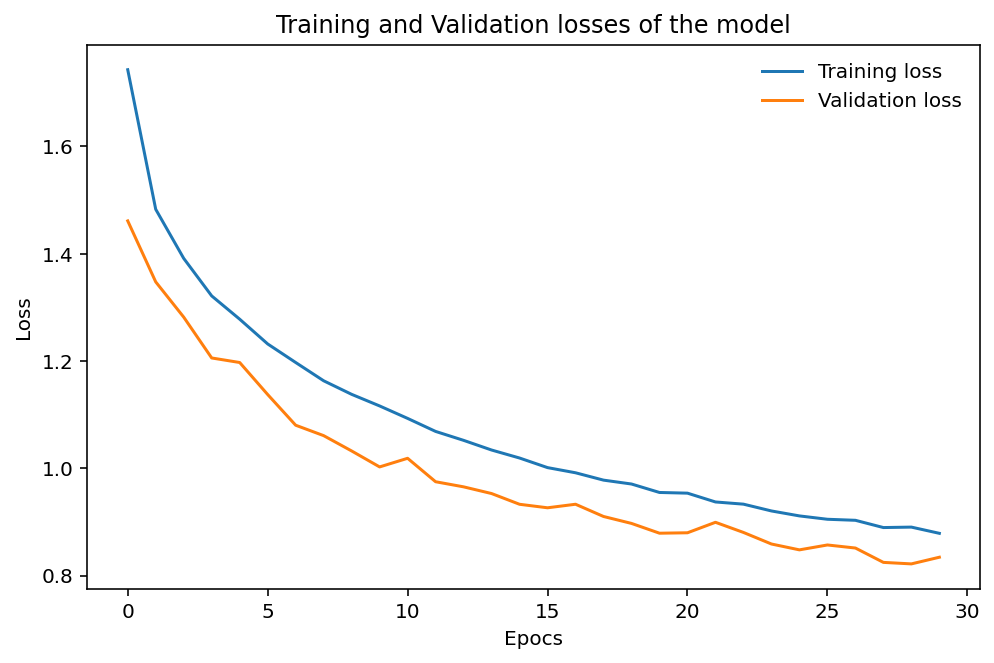

In [12]:
# Plot model's losses
plt.figure(figsize = [8, 5])
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.title('Training and Validation losses of the model')
plt.legend(frameon=False)
plt.show()

As can be seen from the graph below, the validation accuracy of the model reaches a plateau after 30 epochs. Since there is no noticeable increase at the end of 30 epochs, there is no need to increase the number of epochs to further increase the accuracy of the model.

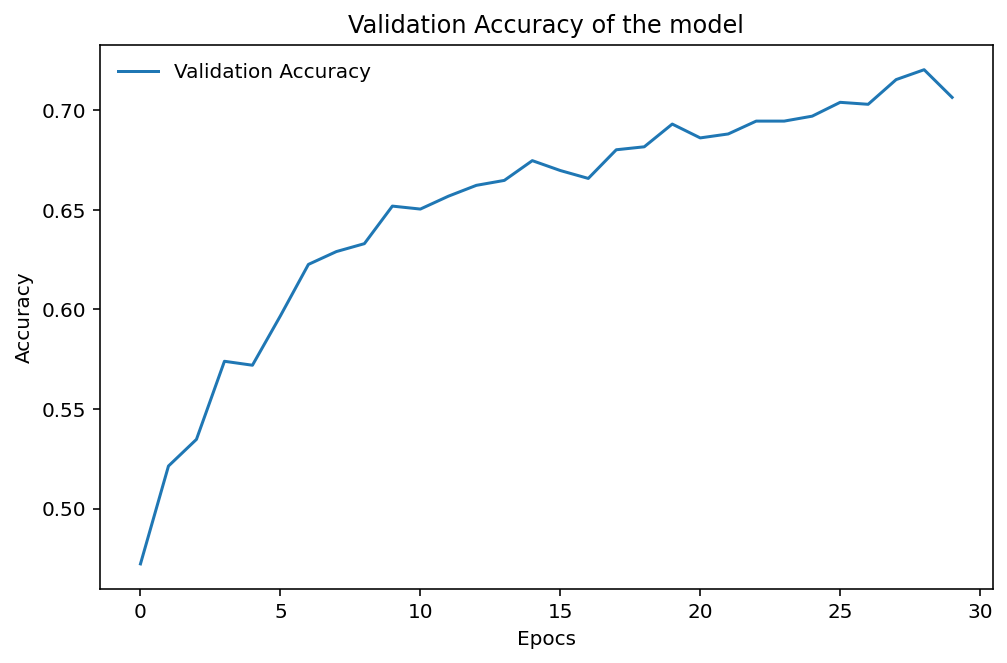

In [13]:
# Plot model's accuracy
plt.figure(figsize = [8, 5])
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epocs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy of the model')
plt.legend(frameon=False)
plt.show()

---
<a id='5.'></a>
## 5. Model Testing
This section evaluates the model based on the test data. Using the previously created test_loader for the test set, a percentage of correct predictions using the highest probability prediction is computed.

In [14]:
accuracy = 0
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
print('Test Accuracy: {:.1f}%'.format(accuracy/len(test_loader)*100))

Test Accuracy: 72.2%


---
<a id='6.'></a>
## 6. Saving the Model
Saving the model for future loading.

In [15]:
CIFAR10_model_checkpoint = {'state_dict': model.state_dict(),
                            'optim_dict':optimizer.state_dict()}

torch.save(CIFAR10_model_checkpoint, 'CIFAR10_model_checkpoint.pth')

---
<a id='7.'></a>
## 7. Recommendation
As can be seen from section 5, it is possible to obtain an accuracy of 72.2% on the CIFAR-10 dataset with a fairly simple model architecture presented in section 4. Similarly, with further research especially considering the academic papers mentioned in section 1.2, it is certain that it is possible to further improve the accuracy of the presented model. Since the presented model, which can be further significantly improved, already has a superior accuracy rate to Detectocorp’s algorithm, which achieved 70% accuracy, Detectocorp’s algorithm should not be purchased, and instead, the model should be built in house. 